In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tensorflow.keras import regularizers

import sys 
import json
import glob
import random
import collections
import time
import re
import math
import numpy as np
import pandas as pd
import cv2

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score

### Load images

In [2]:
# Lets read the train data and the train labels. 
train_data_directory = 'D:/Brain_Tumor_Data/train'
data_directory = 'D:/Brain_Tumor_Data'
IMAGE_SIZE = 128
NUM_IMAGES = 64
def load_dicom_image(path, img_size=IMAGE_SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    return data


def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=IMAGE_SIZE, mri_type="FLAIR", split="test", rotate=0):

    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d,0)

(1, 128, 128, 64)
0.0 1.0 0.06278081447195914 0.00016408131415728857
Dimension of the CT scan is: (128, 128, 64)


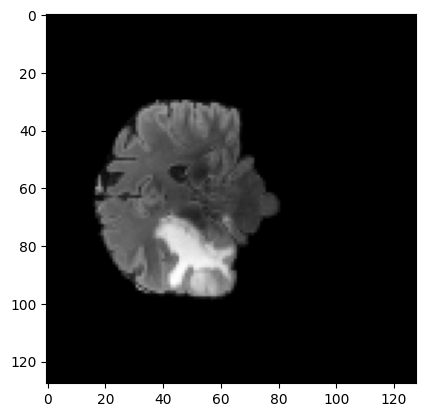

In [3]:
a = load_dicom_images_3d("00001")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))
image = a[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 15]), cmap="gray")

In [4]:
df_train_labels = pd.read_csv('D:/Brain_Tumor_Data/_labels.csv')
df_train_labels.head()

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


In [5]:
train_data_directory = 'D:/Brain_Tumor_Data/train'
print(min(os.listdir(train_data_directory)), max(os.listdir(train_data_directory)))

00000 01010


In [6]:
total_training_scans_F = np.array([load_dicom_images_3d(a, split = 'train') for a in os.listdir(train_data_directory)])
total_training_scans_T1 = np.array([load_dicom_images_3d(a, split = 'train', mri_type="T1w") for a in os.listdir(train_data_directory)])
total_training_scans_T1E = np.array([load_dicom_images_3d(a, split = 'train', mri_type="T1wCE") for a in os.listdir(train_data_directory)])
total_training_scans_T2W = np.array([load_dicom_images_3d(a, split = 'train', mri_type = "T2w") for a in os.listdir(train_data_directory)])

In [7]:
len(total_training_scans_T2W)

585

(585, 1, 128, 128, 64)
585
Dimension of the CT scan is: (1, 128, 128, 64)


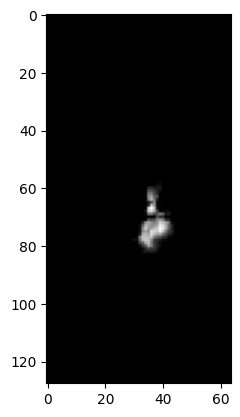

In [8]:
print(total_training_scans_F.shape)
print(len(total_training_scans_F))
image = total_training_scans_F[20]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 25]), cmap="gray")

In [9]:
# Split data
num_train = 374 # 0.64 of 585 samples
num_val = 467 # 0.8 ~~~

x_train_F = np.array([train.T for train in total_training_scans_F[:num_train]])
x_val_F = np.array([train.T for train in total_training_scans_F[num_train:num_val]])
x_test_F = np.array([train.T for train in total_training_scans_F[num_val:]])

x_train_T1 = np.array([train.T for train in total_training_scans_T1[:num_train]])
x_val_T1 = np.array([train.T for train in total_training_scans_T1[num_train:num_val]])
x_test_T1 = np.array([train.T for train in total_training_scans_T1[num_val:]])

x_train_T1E = np.array([train.T for train in total_training_scans_T1E[:num_train]])
x_val_T1E = np.array([train.T for train in total_training_scans_T1E[num_train:num_val]])
x_test_T1E = np.array([train.T for train in total_training_scans_T1E[num_val:]])

x_train_T2W = np.array([train.T for train in total_training_scans_T2W[:num_train]])
x_val_T2W = np.array([train.T for train in total_training_scans_T2W[num_train:num_val]])
x_test_T2W = np.array([train.T for train in total_training_scans_T2W[num_val:]])

In [10]:
print(f"The shape of train: {x_train_T2W.shape}")
print(f"The shape of val: {x_val_T2W.shape}")
print(f"The shape of val: {x_test_T2W.shape}")

The shape of train: (374, 64, 128, 128, 1)
The shape of val: (93, 64, 128, 128, 1)
The shape of val: (118, 64, 128, 128, 1)


In [11]:
total_training_labels = df_train_labels["MGMT_value"].to_list()

In [12]:
total_training_labels = total_training_labels[:585]

In [13]:
len(total_training_labels)

585

In [14]:
y_train = total_training_labels[:num_train]
y_val = total_training_labels[num_train:num_val]
y_test = total_training_labels[num_val:]

### Model

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

In [16]:
def get_model(drop_out, with_data_aug, width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((depth,width, height,1))
    if (with_data_aug):
        x = data_augmentation(inputs)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(drop_out, name="Before_Prediction")(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


In [17]:
with tf.device('/device:GPU:0'):
#     auc_list = []
#     auc_with_data_aug = []
#     count = 0
#     for i in np.arange(0, 1, 0.1):
#     for j in np.arange(2):
    # Build model.
    model_F = get_model(drop_out = 0.8, with_data_aug = 0, width=128, height=128, depth=64)
    model_T1 = get_model(drop_out = 0.4, with_data_aug = 0, width=128, height=128, depth=64)
    model_T1E = get_model(drop_out = 0.8, with_data_aug = 0, width=128, height=128, depth=64)
    model_T2W = get_model(drop_out = 0.9, with_data_aug = 0, width=128, height=128, depth=64)
    # Compile model.
    initial_learning_rate = 0.0001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
    )
    model_F.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=[keras.metrics.AUC(), keras.metrics.BinaryAccuracy(name='acc')],
    )
    model_T1.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=[keras.metrics.AUC(), keras.metrics.BinaryAccuracy(name='acc')],
    )
    model_T1E.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=[keras.metrics.AUC(), keras.metrics.BinaryAccuracy(name='acc')],
    )
    model_T2W.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=[keras.metrics.AUC(), keras.metrics.BinaryAccuracy(name='acc')],
    )

    # Define callbacks.
    checkpoint_F = keras.callbacks.ModelCheckpoint(
       "FLA_MODEL.h5", save_best_only=True
    )
    checkpoint_T1 = keras.callbacks.ModelCheckpoint(
       "T1_MODEL.h5", save_best_only=True
    )
    checkpoint_T1E = keras.callbacks.ModelCheckpoint(
       "T1E_MODEL.h5", save_best_only=True
    )
    checkpoint_T2W = keras.callbacks.ModelCheckpoint(
       "T2W_MODEL.h5", save_best_only=True
    )
    
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)  # TODO

    # Train the model, doing validation at the end of each epoch
    epochs = 10
    history_F = model_F.fit(
        tf.data.Dataset.from_tensor_slices((x_train_F, y_train)).batch(4),
        validation_data=tf.data.Dataset.from_tensor_slices((x_val_F,y_val)).batch(4),
        epochs=epochs,
        shuffle=True,
        verbose=2,
        callbacks=[checkpoint_F, early_stopping_cb],
    )
    history_T1 = model_T1.fit(
        tf.data.Dataset.from_tensor_slices((x_train_T1, y_train)).batch(4),
        validation_data=tf.data.Dataset.from_tensor_slices((x_val_T1,y_val)).batch(4),
        epochs=epochs,
        shuffle=True,
        verbose=2,
        callbacks=[checkpoint_T1, early_stopping_cb],
    )
    history_T1E = model_T1E.fit(
        tf.data.Dataset.from_tensor_slices((x_train_T1E, y_train)).batch(4),
        validation_data=tf.data.Dataset.from_tensor_slices((x_val_T1E,y_val)).batch(4),
        epochs=epochs,
        shuffle=True,
        verbose=2,
        callbacks=[checkpoint_T1E, early_stopping_cb],
    )
    history_T2W = model_T2W.fit(
        tf.data.Dataset.from_tensor_slices((x_train_T2W, y_train)).batch(4),
        validation_data=tf.data.Dataset.from_tensor_slices((x_val_T2W,y_val)).batch(4),
        epochs=epochs,
        shuffle=True,
        verbose=2,
        callbacks=[checkpoint_T2W, early_stopping_cb],
    )
    
#     if (count > 0):
#         if (j):
#             auc_with_data_aug.append(history.history[f'val_auc_{count}'][-1])
#         else:
#             auc_list.append(history.history[f'val_auc_{count}'][-1])
#     else:
#         if (j):
#             auc_with_data_aug.append(history.history['val_auc'][-1])
#         else:
#             auc_list.append(history.history['val_auc'][-1])

#     count += 1



Epoch 1/10
94/94 - 52s - loss: 0.7680 - auc: 0.4996 - acc: 0.4947 - val_loss: 0.6707 - val_auc: 0.4496 - val_acc: 0.6129 - 52s/epoch - 556ms/step
Epoch 2/10
94/94 - 27s - loss: 0.7248 - auc: 0.5547 - acc: 0.5561 - val_loss: 0.7470 - val_auc: 0.5777 - val_acc: 0.3871 - 27s/epoch - 287ms/step
Epoch 3/10
94/94 - 27s - loss: 0.7058 - auc: 0.5782 - acc: 0.5722 - val_loss: 0.7752 - val_auc: 0.5212 - val_acc: 0.3763 - 27s/epoch - 285ms/step
Epoch 4/10
94/94 - 27s - loss: 0.7332 - auc: 0.5488 - acc: 0.5508 - val_loss: 0.7998 - val_auc: 0.4917 - val_acc: 0.3763 - 27s/epoch - 287ms/step
Epoch 5/10
94/94 - 27s - loss: 0.6946 - auc: 0.6094 - acc: 0.5749 - val_loss: 0.8766 - val_auc: 0.4505 - val_acc: 0.3763 - 27s/epoch - 290ms/step
Epoch 6/10
94/94 - 28s - loss: 0.7104 - auc: 0.5914 - acc: 0.5668 - val_loss: 0.6963 - val_auc: 0.4968 - val_acc: 0.5699 - 28s/epoch - 293ms/step
Epoch 7/10
94/94 - 28s - loss: 0.7143 - auc: 0.5777 - acc: 0.5695 - val_loss: 0.6967 - val_auc: 0.5273 - val_acc: 0.5914 - 2

In [18]:
# If have the models in RAM
# If not, then:
#             layer_output_F = keras.load("Fla_model.h5").get_layer("Before_Prediction").output
layer_output_F = model_F.get_layer("Before_Prediction").output
layer_output_T1 = model_T1.get_layer("Before_Prediction").output
layer_output_T1E = model_T1E.get_layer("Before_Prediction").output
layer_output_T2W = model_T2W.get_layer("Before_Prediction").output

feature_extractor_F = keras.Model(
   inputs=model_F.inputs,
   outputs=layer_output_F,
)

feature_extractor_T1 = keras.Model(
   inputs=model_T1.inputs,
   outputs=layer_output_T1,
)

feature_extractor_T1E = keras.Model(
   inputs=model_T1E.inputs,
   outputs=layer_output_T1E,
)

feature_extractor_T2W = keras.Model(
   inputs=model_T2W.inputs,
   outputs=layer_output_T2W,
)

In [19]:
# Practice
a = np.expand_dims(x_train_F[0], axis=0)
a = feature_extractor_F(a)
print(a.shape)
print(x_train_F.shape[0])

(1, 512)
374


In [20]:
# Obtain four features for train
features_F = []
features_T1 = []
features_T1E = []
features_T2W = []
for i in np.arange(0, x_train_F.shape[0], 1):
    features_F.append(feature_extractor_F(np.expand_dims(x_train_F[i], axis=0)))
    features_T1.append(feature_extractor_T1(np.expand_dims(x_train_T1[i], axis=0)))
    features_T1E.append(feature_extractor_T1E(np.expand_dims(x_train_T1E[i], axis=0)))
    features_T2W.append(feature_extractor_T2W(np.expand_dims(x_train_T2W[i], axis=0)))

In [21]:
print(np.array(features_F).shape)

(374, 1, 512)


In [22]:
# Obtain four features for validation
features_F_val = []
features_T1_val = []
features_T1E_val = []
features_T2W_val = []

for i in np.arange(0, x_val_F.shape[0], 1):
    features_F_val.append(feature_extractor_F(np.expand_dims(x_val_F[i], axis=0)))
    features_T1_val.append(feature_extractor_T1(np.expand_dims(x_val_T1[i], axis=0)))
    features_T1E_val.append(feature_extractor_T1E(np.expand_dims(x_val_T1E[i], axis=0)))
    features_T2W_val.append(feature_extractor_T2W(np.expand_dims(x_val_T2W[i], axis=0)))

In [23]:
# Obtain four features for test (development set)
features_F_dev = []
features_T1_dev = []
features_T1E_dev = []
features_T2W_dev = []

for i in np.arange(0, x_test_F.shape[0], 1):
    features_F_dev.append(feature_extractor_F(np.expand_dims(x_test_F[i], axis=0)))
    features_T1_dev.append(feature_extractor_T1(np.expand_dims(x_test_T1[i], axis=0)))
    features_T1E_dev.append(feature_extractor_T1E(np.expand_dims(x_test_T1E[i], axis=0)))
    features_T2W_dev.append(feature_extractor_T2W(np.expand_dims(x_test_T2W[i], axis=0)))

In [24]:
print(np.array(features_F_val).shape)

(93, 1, 512)


In [25]:
print(np.array(features_F_dev).shape)

(118, 1, 512)


In [26]:
# Change data type and shape (Combining)
features_F = np.array(features_F)
features_T1 = np.array(features_T1)
features_T1E = np.array(features_T1E)
features_T2W = np.array(features_T2W)

features_F_val = np.array(features_F_val)
features_T1_val = np.array(features_T1_val)
features_T1E_val = np.array(features_T1E_val)
features_T2W_val = np.array(features_T2W_val)

features_F_dev = np.array(features_F_dev)
features_T1_dev = np.array(features_T1_dev)
features_T1E_dev = np.array(features_T1E_dev)
features_T2W_dev = np.array(features_T2W_dev)


data_train = np.append(features_F, features_T1, axis=2)
data_train = np.append(data_train, features_T1E, axis=2)
data_train = np.append(data_train, features_T2W, axis=2)

data_val = np.append(features_F_val, features_T1_val, axis=2)
data_val = np.append(data_val, features_T1E_val, axis=2)
data_val = np.append(data_val, features_T2W_val, axis=2)

data_dev = np.append(features_F_dev, features_T1_dev, axis=2)
data_dev = np.append(data_dev, features_T1E_dev, axis=2)
data_dev = np.append(data_dev, features_T2W_dev, axis=2)

In [27]:
print(data_dev.shape)

(118, 1, 2048)


In [255]:
def get_big_model(l2_value):
    inputs = keras.Input(shape=(1, 2048))
    features = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(l2_value))(inputs) 
    features = layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2_value))(features)  
    features = layers.Dense(16, activation="relu", kernel_regularizer=regularizers.l2(l2_value))(features)  
    
    # L2 = 0.04 gives auc of 0.607 (epoch 2)

    features = layers.Dropout(0.3)(features) # loop                                        

    output_lay = layers.Dense(units=1, activation="sigmoid")(features)
    model = keras.Model(inputs, outputs=output_lay)
    return model

In [282]:
# Check data shape and fit the need for the model
print(f"train data shape: {data_train.shape}")
print(f"val data shape: {data_val.shape}")

y_train_np = np.expand_dims(y_train, axis=1)
y_val_np = np.expand_dims(y_val, axis=1)

print(f"train label shape: {y_train_np.shape}")
print(f"val label shape: {y_val_np.shape}")

# Compile the model
# values_interested = [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 
#                      0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
values_interested = [0.06]
for l2_value in values_interested:
    print(l2_value)
    model = get_big_model(l2_value)
    model.compile(loss="binary_crossentropy", 
                  optimizer="rmsprop",
                  metrics=[keras.metrics.AUC(), keras.metrics.BinaryAccuracy(name='acc')])

    checkpoint_cb = keras.callbacks.ModelCheckpoint(
                   "BIG_MODEL.h5", save_best_only=True
                )
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_auc", patience=15)  # TODO lower the value, patience = 5
    
#   early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)



    history = model.fit(
                    tf.data.Dataset.from_tensor_slices((data_train, y_train_np)).batch(4),  # batch : 2
                    validation_data=tf.data.Dataset.from_tensor_slices((data_val, y_val_np)).batch(4),
                    epochs=10,
                    shuffle=True,
                    verbose=2,
                    callbacks=[checkpoint_cb, early_stopping_cb],
                )
    
# predict development set
y_dev_np = np.expand_dims(y_test, axis=1)

print(f"Test (development set) AUC: {roc_auc_score(y_dev_np, np.squeeze(model.predict(data_dev), axis=1))}")

train data shape: (374, 1, 2048)
val data shape: (93, 1, 2048)
train label shape: (374, 1)
val label shape: (93, 1)
0.06
Epoch 1/10
94/94 - 2s - loss: 3.9377 - auc_133: 0.4875 - acc: 0.5080 - val_loss: 1.8825 - val_auc_133: 0.5402 - val_acc: 0.6129 - 2s/epoch - 18ms/step
Epoch 2/10
94/94 - 1s - loss: 1.3261 - auc_133: 0.5466 - acc: 0.5374 - val_loss: 0.9228 - val_auc_133: 0.5341 - val_acc: 0.6129 - 649ms/epoch - 7ms/step
Epoch 3/10
94/94 - 1s - loss: 0.7920 - auc_133: 0.5394 - acc: 0.5455 - val_loss: 0.7165 - val_auc_133: 0.4949 - val_acc: 0.6129 - 654ms/epoch - 7ms/step
Epoch 4/10
94/94 - 0s - loss: 0.7016 - auc_133: 0.5027 - acc: 0.4973 - val_loss: 0.6933 - val_auc_133: 0.5000 - val_acc: 0.6129 - 485ms/epoch - 5ms/step
Epoch 5/10
94/94 - 1s - loss: 0.6959 - auc_133: 0.4545 - acc: 0.4733 - val_loss: 0.6939 - val_auc_133: 0.5000 - val_acc: 0.6129 - 661ms/epoch - 7ms/step
Epoch 6/10
94/94 - 1s - loss: 0.6953 - auc_133: 0.5052 - acc: 0.4706 - val_loss: 0.6933 - val_auc_133: 0.5000 - val_

In [283]:
model.predict(data_dev)

4/4 [==============================] - 0s 4ms/step


array([[[0.5059147 ]],

       [[0.5059132 ]],

       [[0.50591296]],

       [[0.50591236]],

       [[0.505913  ]],

       [[0.50592256]],

       [[0.5059117 ]],

       [[0.5059144 ]],

       [[0.50591296]],

       [[0.5059114 ]],

       [[0.50591284]],

       [[0.50591135]],

       [[0.50591284]],

       [[0.5059127 ]],

       [[0.5059132 ]],

       [[0.5059119 ]],

       [[0.50592214]],

       [[0.5059136 ]],

       [[0.5059123 ]],

       [[0.50591236]],

       [[0.5059209 ]],

       [[0.50591826]],

       [[0.5059126 ]],

       [[0.50591165]],

       [[0.5059116 ]],

       [[0.50591356]],

       [[0.50591165]],

       [[0.5059129 ]],

       [[0.505912  ]],

       [[0.50591695]],

       [[0.50591195]],

       [[0.5059119 ]],

       [[0.50591284]],

       [[0.5059164 ]],

       [[0.50592047]],

       [[0.50591236]],

       [[0.5059119 ]],

       [[0.50591326]],

       [[0.5059139 ]],

       [[0.5059125 ]],

       [[0.5059123 ]],

       [[0.50591